In [1]:
import h5py as h5
import numpy as np
import neuraltda.SimplicialComplex as sc
import matplotlib.pyplot as plt
%matplotlib inline
reload(sc)

<module 'neuraltda.SimplicialComplex' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/SimplicialComplex.pyc'>

In [2]:
fname = '/Users/brad/test_binned_data/B1235_cat_P01_S01_1-good-50ms-stim.binned'
f = h5.File(fname, 'r')

In [ ]:
stimdata = f['A_scaled_burung']
trialdata = stimdata['0']

In [3]:
def binnedtobinary(popvec, thresh):
    
    popvec = np.array(popvec)
    Ncells, Nwin = np.shape(popvec)
    means = popvec.sum(1)/Nwin
    means = np.tile(means, (Nwin, 1)).T
    meanthr = thresh*means
    
    activeUnits = np.greater(popvec, meanthr).astype(int)
    return activeUnits
    
def BinaryToMaxSimplex(binMat):
    
    Ncells, Nwin = np.shape(binMat)
    MaxSimps = []
    for cell in range(Ncells):
        if binMat[cell, :].any():
            verts = np.arange(Nwin)[binMat[cell, :] == 1]
            verts = np.sort(verts)
            MaxSimps.append(list(verts))
    return MaxSimps
        
def ShuffleBinary(binMat):
    retMat = np.array(binMat)
    Ncells, Nwin = np.shape(binMat)
    for cell in range(Ncells):
        np.random.shuffle(retMat[cell, :])
    return retMat
        
    

In [ ]:
popvec = trialdata['pop_vec'][:10, :]

tst = binnedtobinary(popvec, 6.0)
tst_shuffled = ShuffleBinary(tst)
tst2 = BinaryToMaxSimplex(tst)
tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
print(tst2)
print(tst2_shuffled)

In [ ]:
spikeComplex = sc.SimplicialComplex(tst2)
spikeComplex.updateAdjacency()
shuffledspikeComplex = sc.SimplicialComplex(tst2_shuffled)
shuffledspikeComplex.updateAdjacency()

In [ ]:
print( [len(spikeComplex.nSimplexDict[s]) for s in range(spikeComplex.dimension)])
print( [len(shuffledspikeComplex.nSimplexDict[s]) for s in range(shuffledspikeComplex.dimension)])

In [ ]:
dsimps = spikeComplex.nSimplexDict[4]
nsimps = len(dsimps)
s1 = dsimps[4]
s2 = dsimps[123]
s1c = s1.cofaces
s2c = s2.cofaces


In [ ]:
dim=3
spec = spikeComplex.getSpectrum(dim)
specshuff = shuffledspikeComplex.getSpectrum(dim)
print(spec)
print(specshuff)

In [ ]:
plt.plot(range(len(spec)), np.sort(spec),'r.', range(len(specshuff)), np.sort(specshuff), 'b.')

In [ ]:
popvec = trialdata['pop_vec'][:, :]

tst = binnedtobinary(popvec, 6.0)
tst_shuffled = ShuffleBinary(tst)
tst = np.transpose(tst)
tst_shuffled = np.transpose(tst_shuffled)
tst2 = BinaryToMaxSimplex(tst)
tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
print(tst[3, :])


In [ ]:
spikeComplexT = sc.SimplicialComplex(tst2)
spikeComplexT.updateAdjacency()
shuffledspikeComplexT = sc.SimplicialComplex(tst2_shuffled)
shuffledspikeComplexT.updateAdjacency()

In [ ]:
print( [len(spikeComplexT.nSimplexDict[s]) for s in range(spikeComplexT.dimension)])
print( [len(shuffledspikeComplexT.nSimplexDict[s]) for s in range(shuffledspikeComplexT.dimension)])

In [ ]:
dim=5
spec = spikeComplexT.getSpectrum(dim)
specshuff = shuffledspikeComplexT.getSpectrum(dim)
print(spec)
print(specshuff)
plt.plot(range(len(spec)), np.sort(spec),'r.', range(len(specshuff)), np.sort(specshuff), 'b.')

In [12]:
def computeSpectrogram(spec, sigma, lam):
    
    sig = np.zeros(np.shape(lam))
    for eigval in spec:
        gaussian = np.exp(-(lam-eigval)**2 / (2*sigma**2)) / (np.sqrt(2*np.pi*sigma**2))
        sig = sig+gaussian
    return sig

In [ ]:
t = np.linspace(0, 18, 1000)
specg = computeSpectrogram(spec, 0.05, t)

In [4]:
def computeAvgSpectrogram(stimdata, thresh, sigma, dim):
    
    t = np.linspace(0, 100, 5000)
    sigspec = np.zeros(t.shape)
    sigspecshuff = np.zeros(t.shape)
    ntrials = len(stimdata.keys())
    for trial in stimdata.keys():
        popvec = np.array(stimdata[trial]['pop_vec'])
        tst = binnedtobinary(popvec, thresh)
        tst_shuffled = ShuffleBinary(tst)
        tst = np.transpose(tst)
        tst_shuffled = np.transpose(tst_shuffled)
        tst2 = BinaryToMaxSimplex(tst)
        tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
        
        print('Creating spike complexes for trial: %s' % trial)
        spikeComplex = sc.SimplicialComplex(tst2)
        spikeComplex.updateAdjacency()
        shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
        shuffledSpikeComplex.updateAdjacency()
        try:
            spec = spikeComplex.getSpectrum(dim)
            sigspec = sigspec + computeSpectrogram(spec, sigma, t)
        except KeyError:
            sigspec = sigspec + np.zeros(t.shape)
        try:
            specshuff = shuffledSpikeComplex.getSpectrum(dim)
            sigspecshuff = sigspecshuff + computeSpectrogram(specshuff, sigma, t)
        except KeyError:
            sigspecshuff = sigspecshuff + np.zeros(t.shape)            
    sigspec = sigspec/(float(ntrials))
    sigspecshuff = sigspecshuff/(float(ntrials))
    
    return (sigspec, sigspecshuff)

def computeTrialSpectrograms(stimdata, thresh, sigma, dim):
    
    tlen = 5000
    t = np.linspace(0, 100, tlen)

    ntrials = len(stimdata.keys())
    sigspec = np.zeros((ntrials, tlen))
    sigspecshuff = np.zeros((ntrials, tlen))
    for trialnum, trial in enumerate(stimdata.keys()):
        popvec = np.array(stimdata[trial]['pop_vec'])
        tst = binnedtobinary(popvec, thresh)
        tst_shuffled = ShuffleBinary(tst)
        tst = np.transpose(tst)
        tst_shuffled = np.transpose(tst_shuffled)
        tst2 = BinaryToMaxSimplex(tst)
        tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
        
        print('Creating spike complexes for trial: %s' % trial)
        spikeComplex = sc.SimplicialComplex(tst2)
        spikeComplex.updateAdjacency()
        shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
        shuffledSpikeComplex.updateAdjacency()
        try:
            spec = spikeComplex.getSpectrum(dim)
            sigspec[trialnum, :] = computeSpectrogram(spec, sigma, t)
        except KeyError:
            sigspec[trialnum, :] = np.zeros(t.shape)
        try:
            specshuff = shuffledSpikeComplex.getSpectrum(dim)
            sigspecshuff[trialnum, :] = computeSpectrogram(specshuff, sigma, t)
        except KeyError:
            sigspecshuff[trialnum, :] = np.zeros(t.shape)            
    
    return (sigspec, sigspecshuff)

def computeAvgSpectrogramOld(stimdata, thresh, sigma, dim):
    
    t = np.linspace(0, 100, 5000)
    sigspec = np.zeros(t.shape)
    sigspecshuff = np.zeros(t.shape)
    ntrials = len(stimdata.keys())
    for trial in stimdata.keys():
        popvec = np.array(stimdata[trial]['pop_vec'])
        tst = binnedtobinary(popvec, thresh)
        tst_shuffled = ShuffleBinary(tst)
        tst = np.transpose(tst)
        tst_shuffled = np.transpose(tst_shuffled)
        tst2 = BinaryToMaxSimplex(tst)
        tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)

        print('Creating spike complexes for trial: %s' % trial)
        spikeComplex = sc.SimplicialComplex(tst2)
        spikeComplex.updateAdjacency()
        shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
        shuffledSpikeComplex.updateAdjacency()
        spec = spikeComplex.getSpectrum(dim)
        sigspec = sigspec + computeSpectrogram(spec, sigma, t)

        specshuff = shuffledSpikeComplex.getSpectrum(dim)
        sigspecshuff = sigspecshuff + computeSpectrogram(specshuff, sigma, t)
         
    sigspec = sigspec/(float(ntrials))
    sigspecshuff = sigspecshuff/(float(ntrials))
    
    return (sigspec, sigspecshuff)
        

In [ ]:
fname = '/home/brad/B1235_cat_P01_S01_1-good-50ms-stim.binned'
fname = '/mnt/cube/btheilma/experiments/B1087/phy040516/Pen03_Lft_AP0_ML500__Site02_Z2500__B1087_cat_P03_S02_1/binned_data/20160909T194413Z/20160909T194413Z-50.binned'
f = h5.File(fname, 'r')
print(f.keys())
stimAdata = f['I_40k']
stimBdata = f['J_40k']

In [ ]:
fname = '/Users/brad/test_binned_data/B1235_cat_P01_S01_1-good-50ms-stim.binned'
f = h5.File(fname, 'r')
print(f.keys())
stimAdata = f['A_scaled_burung']
stimBdata = f['B_scaled_burung']

In [ ]:
thresh = 4.0
dim = 2
sigA, sigAshuff = computeAvgSpectrogram(stimAdata, thresh, 0.05, dim)
sigB, sigBshuff = computeAvgSpectrogram(stimBdata, thresh, 0.05, dim)

In [ ]:
sigAtrial, sigAtrialshuff = computeTrialSpectrograms(stimAdata, thresh, 0.05, dim)

In [ ]:
t = np.linspace(0, 100, 5000)
lim = 1000
plt.plot(t[:lim], sig[:lim], 'r', t[:lim], sigshuff[:lim], 'b')
plt.ylim([0, 100])

In [ ]:
t = np.linspace(0, 100, 5000)
plt.plot(t[:600], sigo[:600], 'r', t[:600], sigshuffo[:600], 'b')

In [ ]:
t = np.linspace(0, 100, 5000)
lim = 1500
ymax = 1000
plt.figure(figsize=(11,11))
plt.plot(t[:lim], sigA[:lim], 'r', t[:lim], sigAshuff[:lim], 'b', t[:lim], sigB[:lim], 'g', t[:lim], sigBshuff[:lim], 'k')
plt.ylim([0, ymax])
plt.title('Dimension %d Simplicial Spectrogram: Stimulus A vs. Stimulus C' % dim)
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.legend(['Stim A Real', 'Stim A Shuffle', 'Stim C Real', 'Stim C Shuffle'])

In [ ]:
t = np.linspace(0, 100, 5000)
lim = 2000
ymax = 3000
plt.figure(figsize=(11,11))
plt.plot(t[:lim], sigA[:lim],'r.', t[:lim], np.transpose(sigAtrial[:, :lim]))
plt.ylim([0, ymax])
plt.title('Dimension 2 Simplicial Spectrogram: Stimulus A Average vs. Trials')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')

In [ ]:
t = np.linspace(0, 100, 5000)
lim = 1000
ymax = 5
plt.figure(figsize=(11,11))
plt.plot(t[:lim], np.log10(sigA[:lim]),'r.', t[:lim], np.log10(np.transpose(sigAtrial[:, :lim])))
plt.ylim([0, ymax])
plt.title('Dimension 2 Simplicial Spectrogram: Stimulus A Average vs. Trials')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')

In [ ]:
t = np.linspace(0, 100, 5000)
lim = 2000
ymax = 6
plt.figure(figsize=(11,11))
sigAlog = np.log(sigA)
sigAslog = np.log(sigAshuff)
sigBlog = np.log(sigB)
sigBslog = np.log(sigBshuff)
plt.plot(t[:lim], sigAlog[:lim], 'r', t[:lim], sigAslog[:lim], 'b', t[:lim], sigBlog[:lim], 'g', t[:lim], sigBslog[:lim], 'k')
plt.ylim([0, ymax])
plt.title('Dimension 2 Simplicial Spectrogram: Stimulus A vs. Stimulus C')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.legend(['Stim A Real', 'Stim A Shuffle', 'Stim C Real', 'Stim C Shuffle'])

In [ ]:
def makeChord(spec, lam, t):
    
    sig = np.zeros(t.shape)
    maxval = max(spec)
    normspec = spec/float(maxval)
    
    for indx,val in enumerate(normspec):
        sig = sig+val*np.sin(2*np.pi*256*lam[indx]*t)
    return sig

In [ ]:
from scipy.signal import convolve
import numpy as np
from matplotlib import pyplot as plt

Y = -sigB

#Obtaining derivative
kernel = [1, 0, -1]
dY = convolve(Y, kernel, 'valid') 

#Checking for sign-flipping
S = np.sign(dY)
ddS = convolve(S, kernel, 'valid')

#These candidates are basically all negative slope positions
#Add one since using 'valid' shrinks the arrays
candidates = np.where(dY < 0)[0] + (len(kernel) - 1)

#Here they are filtered on actually being the final such position in a run of
#negative slopes
peaks = sorted(set(candidates).intersection(np.where(ddS == 2)[0] + 1))

plt.plot(Y)

#If you need a simple filter on peak size you could use:
alpha = -30
peaks = np.array(peaks)[Y[peaks] < alpha]
plt.scatter(peaks, Y[peaks], marker='x', color='g', s=40)

In [ ]:
tpeaksA = t[peaks]
sigApeaks = sigA[peaks]
tpeaksB = t[peaks]
sigBpeaks = sigB[peaks]

fs = 20000
dur=5
samps = dur*fs
testsoundA = makeChord(sigA, t, np.linspace(0, dur, samps))
testsoundB = makeChord(sigBpeaks, tpeaksB, np.linspace(0, dur, samps))

In [ ]:
plt.plot(testsoundA)

In [ ]:
from scipy.io.wavfile import write

write('testsoundA.wav', fs, testsoundA.astype(float))
write('testsoundB.wav', fs, testsoundB.astype(float))

In [ ]:
fname = '/Users/brad/test_binned_data/B1235_cat_P01_S01_1-good-50ms-stim.binned'
f = h5.File(fname, 'r')
stimdata = f['A_scaled_burung']
trialdata = stimdata['0']
popvec = trialdata['pop_vec'][:10, :]

tst = binnedtobinary(popvec, 6.0)
tst2 = BinaryToMaxSimplex(tst)
spikeComplex = sc.SimplicialComplex(tst2)
spikeComplex.updateAdjacency()

In [ ]:
LDown1 = spikeComplex.computeLowerLaplacianDirect(2)
LUp1 = spikeComplex.computeUpperLaplacianDirect(2)

In [ ]:
(LUp1 + LDown1).shape

In [ ]:
L = spikeComplex.getLaplacian(2)

In [ ]:
(LUp1 + LDown1)

In [ ]:
LDown1

In [ ]:
LUp1

In [ ]:
tstSimp = [[1,2,3], [3,4]]
tstSimpComp = sc.SimplicialComplex(tstSimp)
tstSimpComp.updateAdjacency()

In [ ]:
Ld = tstSimpComp.getBoundaryMap(2)

In [ ]:
Lu = tstSimpComp.getBoundaryMap(1)

In [ ]:
dim = 0
inds = [(tstSimpComp.nSimplexDict[dim][i].index, tstSimpComp.nSimplexDict[dim][i].vertices) for i in range(len(tstSimpComp.nSimplexDict[dim]))]
print(inds)

In [ ]:
dim = 1
inds = [(tstSimpComp.nSimplexDict[dim][i].index, tstSimpComp.nSimplexDict[dim][i].vertices) for i in range(len(tstSimpComp.nSimplexDict[dim]))]
print(inds)

In [ ]:
[1,2,3,4] - [1,2,3]

In [ ]:
a = [1,2,3,4]
t=set((1,2,3,4)) - set((1,2,3))

In [ ]:
a == 4

In [ ]:
a.index(list(t)[0])

In [ ]:
tstSimpComp.getLaplacian(1)

In [ ]:
np.dot(Ld, np.transpose(Ld))

In [ ]:
np.dot(np.transpose(Lu), Lu)

In [ ]:
Ld

In [ ]:
fname = '/Users/brad/test_binned_data/B1235_cat_P01_S01_1-good-50ms-stim.binned'
f = h5.File(fname, 'r')
print(f.keys())
stimAdata = f['A_scaled_burung']
stimBdata = f['B_scaled_burung']

stimdata = f['A_scaled_burung']
trialdata = stimdata['0']
popvec = trialdata['pop_vec'][:, :]

tst = binnedtobinary(popvec, 4.0)
tst = np.transpose(tst)
tst2 = BinaryToMaxSimplex(tst)

spikeComplex = sc.SimplicialComplex(tst2)
spikeComplex.updateAdjacency()

In [ ]:
dim = 9
np.sort(spikeComplex.getSpectrum(dim))

In [5]:
from scipy.io import savemat
def computeSpectraAllTrials(binnedDataset, thresh):
    
    stimuli = binnedDataset.keys()
    nStim = len(stimuli)
    
    spectrumDict = {}
    for stimIndx, stim in enumerate(stimuli):
        print('Computing spectrum for stimulus: %s' % stim)
        stimData = binnedDataset[stim]
        stimDict = {}
        trials = stimData.keys()
        nTrials = len(trials)
        
        t = np.linspace(0, 100, 5000)
    
        for trial in stimData.keys():
            trialSpectrumDict = {}
            trialDict = {}
            trialShuffleSpectrumDict = {}
            popvec = np.array(stimData[trial]['pop_vec'])
            tst = binnedtobinary(popvec, thresh)
            tst_shuffled = ShuffleBinary(tst)
            tst = np.transpose(tst)
            tst_shuffled = np.transpose(tst_shuffled)
            tst2 = BinaryToMaxSimplex(tst)
            tst2_shuffled = BinaryToMaxSimplex(tst_shuffled)
        
            #print('Creating spike complexes for trial: %s' % trial)
            spikeComplex = sc.SimplicialComplex(tst2)
            spikeComplex.updateAdjacency()
            shuffledSpikeComplex = sc.SimplicialComplex(tst2_shuffled)
            shuffledSpikeComplex.updateAdjacency()
            
            scDim = spikeComplex.dimension
            sscDim = shuffledSpikeComplex.dimension
            for sDim in range(scDim):
                #print('Dimension: %d' % sDim)
                try:
                    spec = spikeComplex.getSpectrum(sDim)     
                except KeyError:
                    spec = np.zeros(t.shape)
                trialSpectrumDict[sDim] = spec
            for ssDim in range(sscDim):
                #print('Shuffled Dimension: %d' % ssDim)
                try:
                    specshuff = shuffledSpikeComplex.getSpectrum(ssDim)
                except KeyError:
                    specshuff = np.zeros(t.shape)    
                trialShuffleSpectrumDict[ssDim] = specshuff
            trialDict['real'] = trialSpectrumDict
            trialDict['shuffle'] = trialShuffleSpectrumDict
            stimDict[trial] = trialDict
        spectrumDict[stim] = stimDict
    print('Writing matfile...')
    savemat('SimplicialLaplacianSpectrum', spectrumDict)
    return spectrumDict

In [6]:
specDict = computeSpectraAllTrials(f, 6.0)

Computing spectrum for stimulus: A_scaled_burung
Computing spectrum for stimulus: B_scaled_burung
Computing spectrum for stimulus: C_scaled_burung
Computing spectrum for stimulus: D_scaled_burung
Computing spectrum for stimulus: E_scaled_burung
Computing spectrum for stimulus: F_scaled_burung
Computing spectrum for stimulus: G_scaled_burung
Computing spectrum for stimulus: H_scaled_burung
Computing spectrum for stimulus: I_scaled_burung
Computing spectrum for stimulus: J_scaled_burung
Computing spectrum for stimulus: K_scaled_burung
Computing spectrum for stimulus: L_scaled_burung
Computing spectrum for stimulus: M_scaled_burung
Computing spectrum for stimulus: N_scaled_burung
Computing spectrum for stimulus: O_scaled_burung
Computing spectrum for stimulus: P_scaled_burung
Writing matfile...


In [8]:
import pickle
with open('SimplicialLaplacianSpectrumPkl.pkl', 'w') as fpkl:
    pickle.dump(specDict, fpkl)

In [11]:
specDict['A_scaled_burung'].keys()

[u'11',
 u'10',
 u'13',
 u'12',
 u'15',
 u'14',
 u'17',
 u'16',
 u'19',
 u'18',
 u'1',
 u'0',
 u'3',
 u'2',
 u'5',
 u'4',
 u'7',
 u'6',
 u'9',
 u'8']

In [19]:
tlen = 5000
t = np.linspace(0, 100, tlen)
sigma = 0.05
maxdim = 20
def computeAvgSpectraAllStims(spectrumDict):
    
    avgSpectrumDict = {}
    for stim in spectrumDict.keys():
        
        stimSpec = spectrumDict[stim]
        avgSpectrum = np.zeros((tlen, maxdim))
        ntrials = len(stimSpec.keys())
        for trial in stimSpec.keys():
            trialData = stimSpec[trial]['real']
            for dim in trialData.keys():
                avgSpectrum[:, int(dim)] = avgSpectrum[:, int(dim)] + computeSpectrogram(trialData[int(dim)], sigma, t)
        avgSpectrum = avgSpectrum / float(ntrials)
        avgSpectrumDict[stim] = avgSpectrum
    return avgSpectrumDict



In [21]:
avgs = computeAvgSpectraAllStims(specDict)

/Users/brad/anaconda/envs/neuraltda/lib/python2.7/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part


In [26]:
axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ae23690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1147a2890>]], dtype=object)

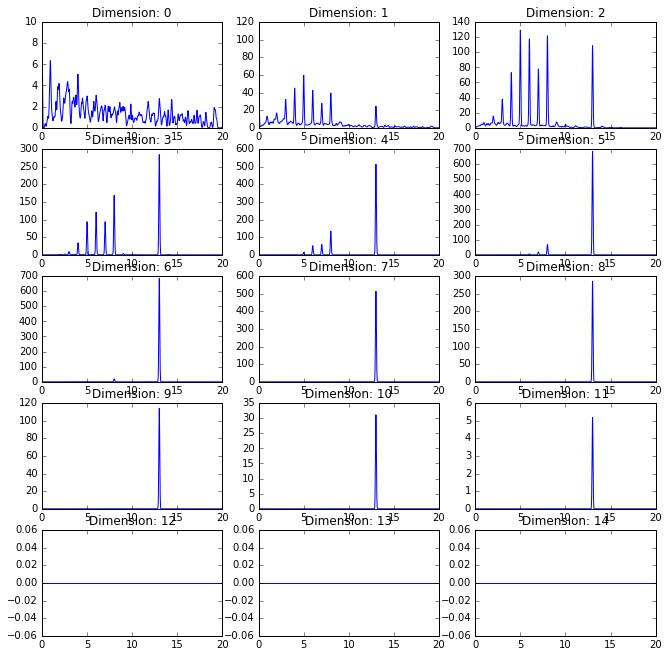

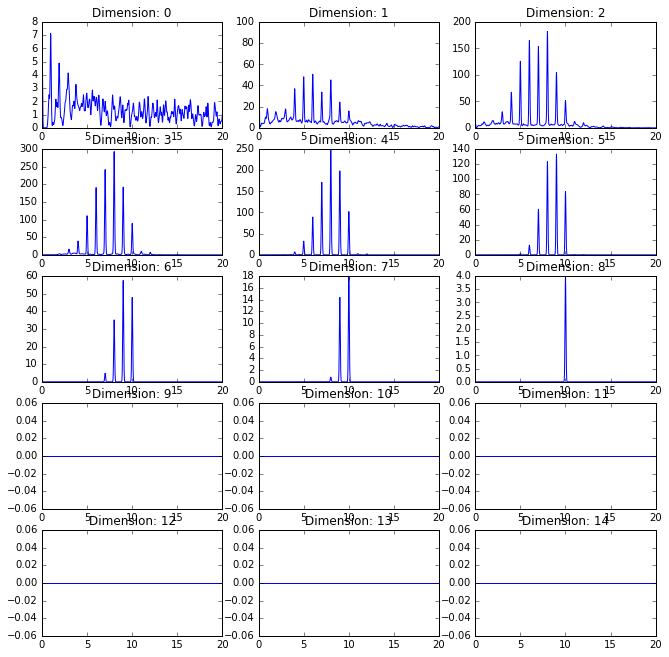

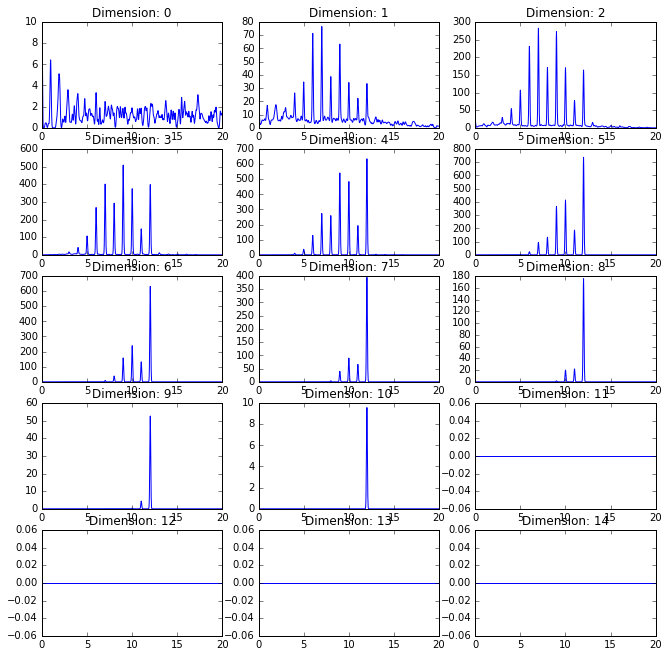

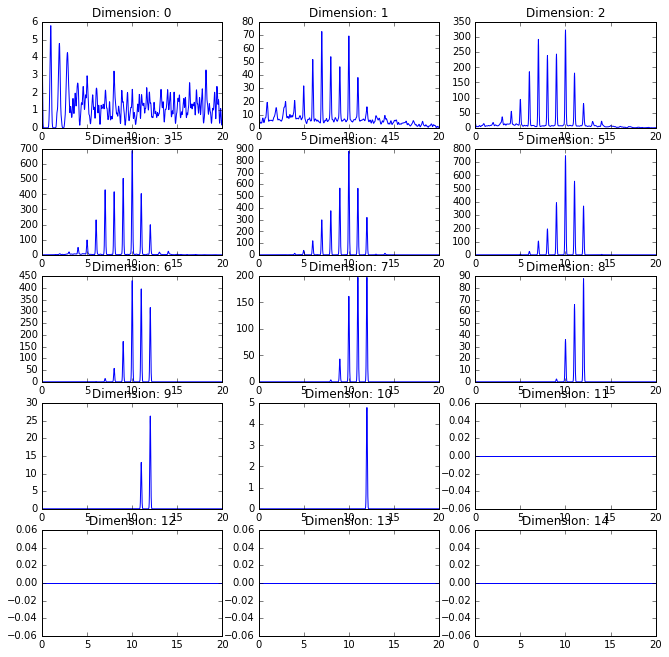

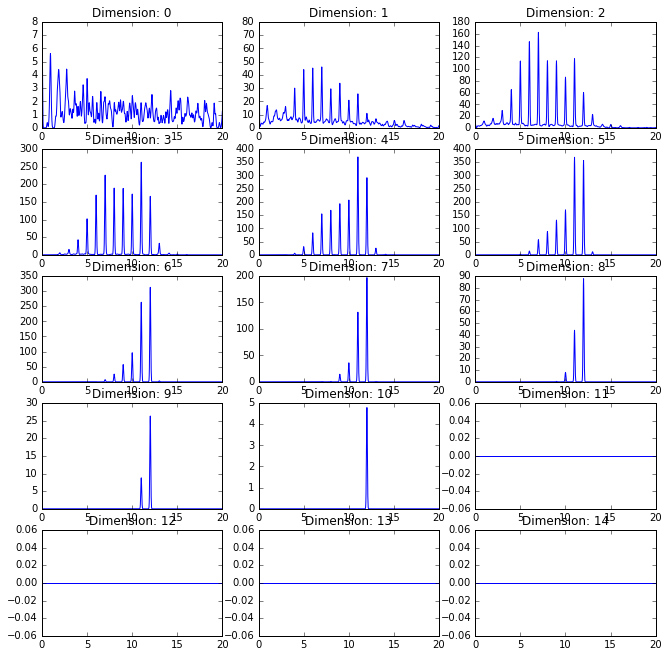

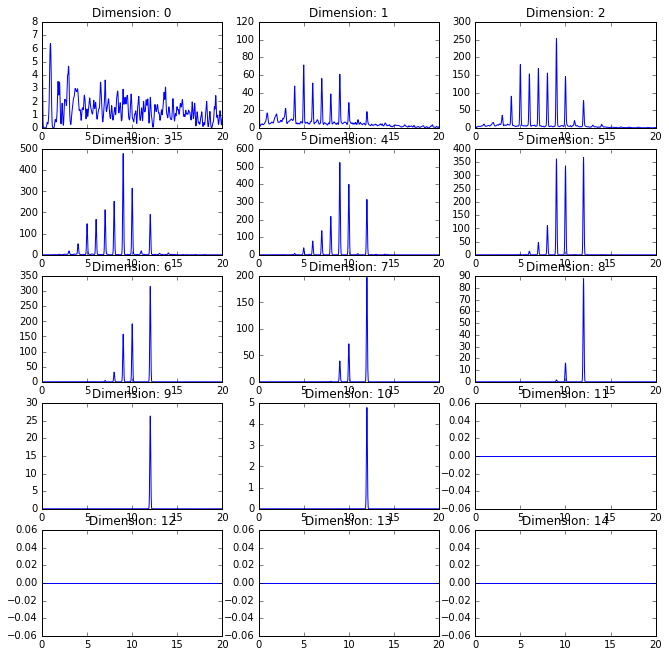

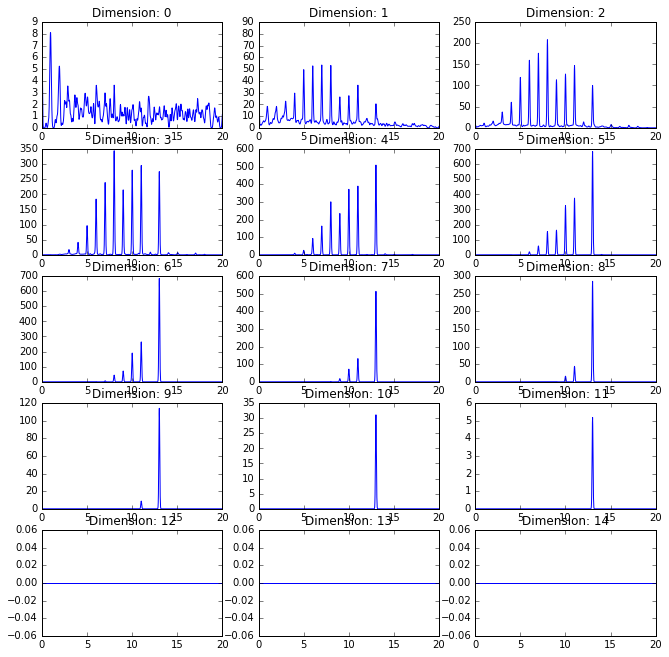

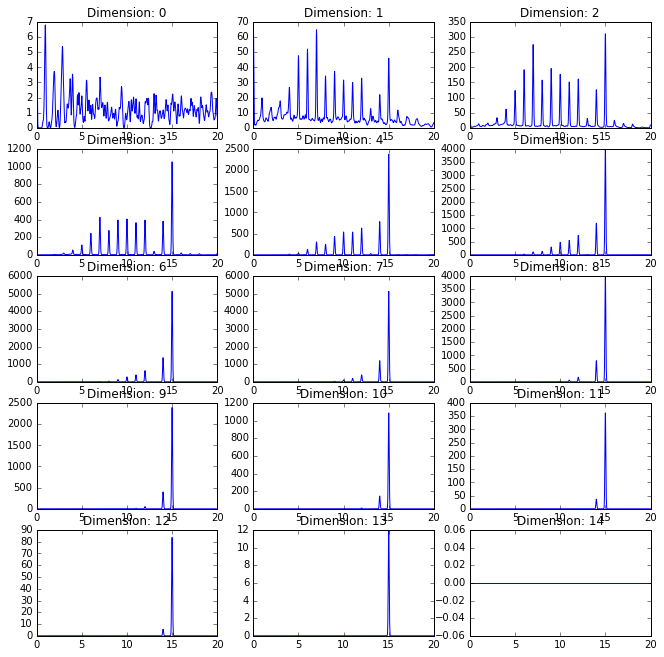

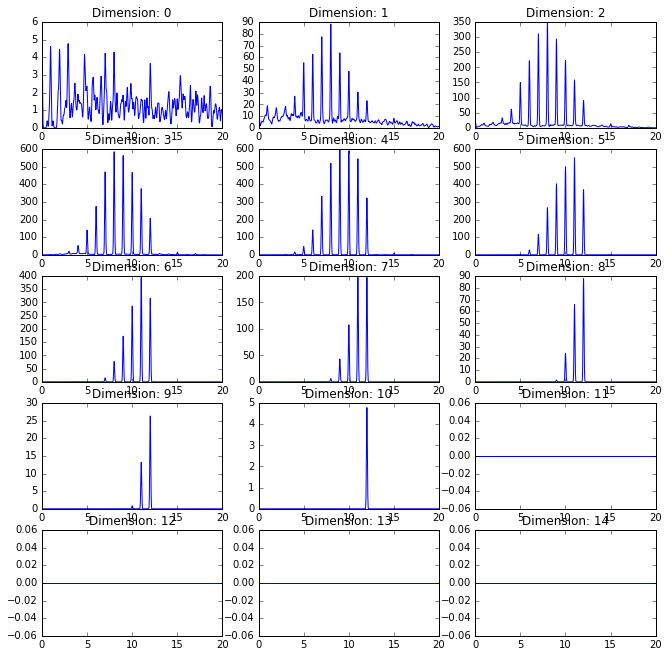

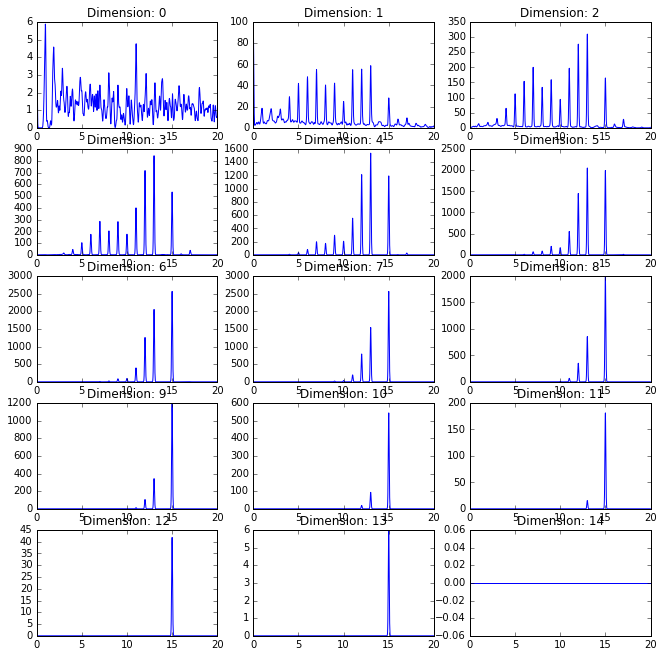

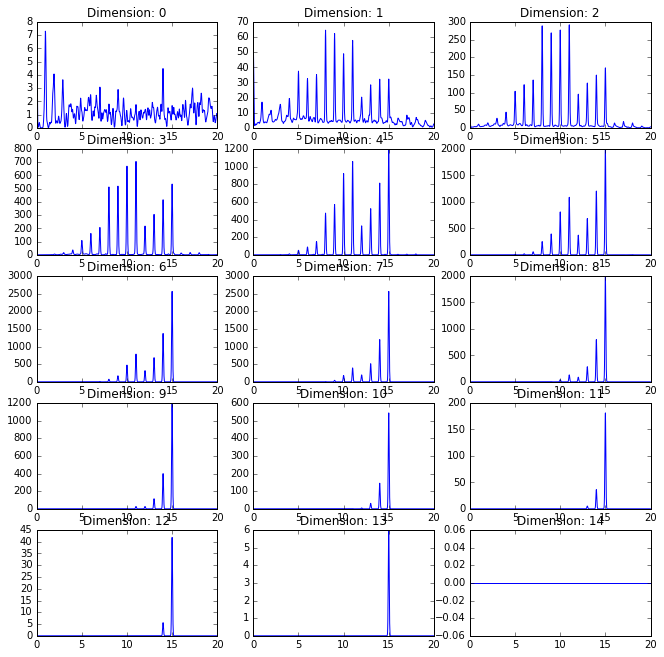

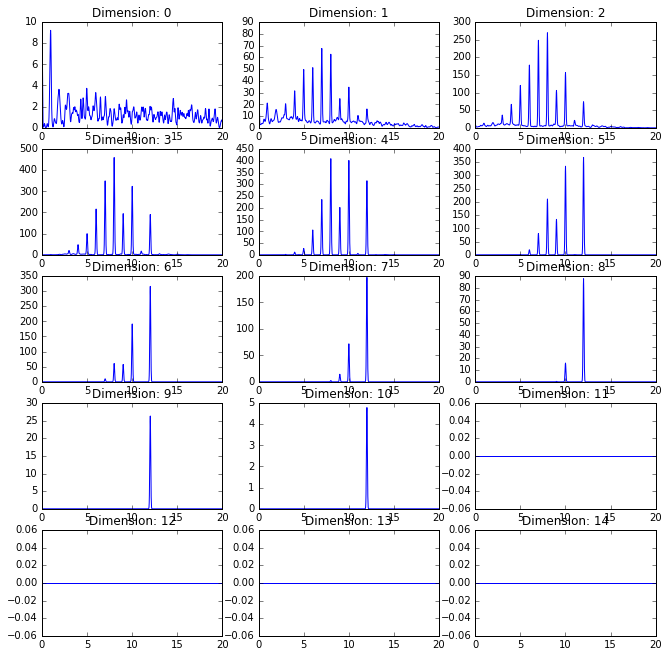

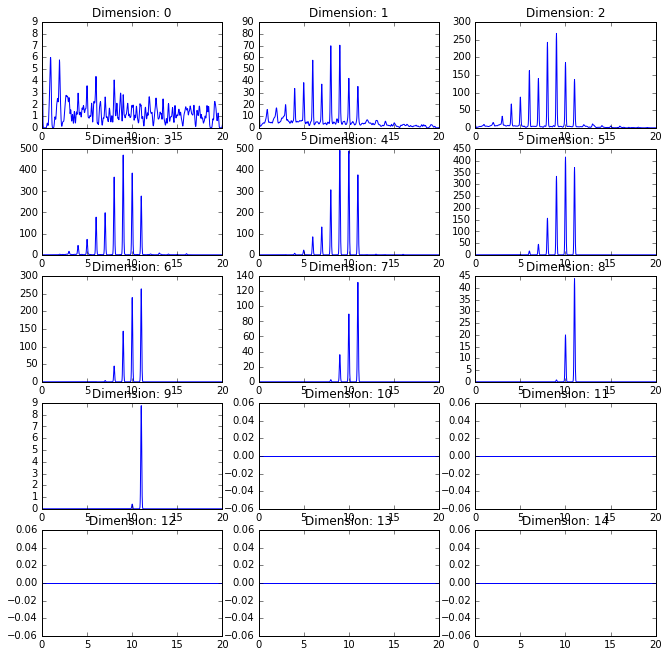

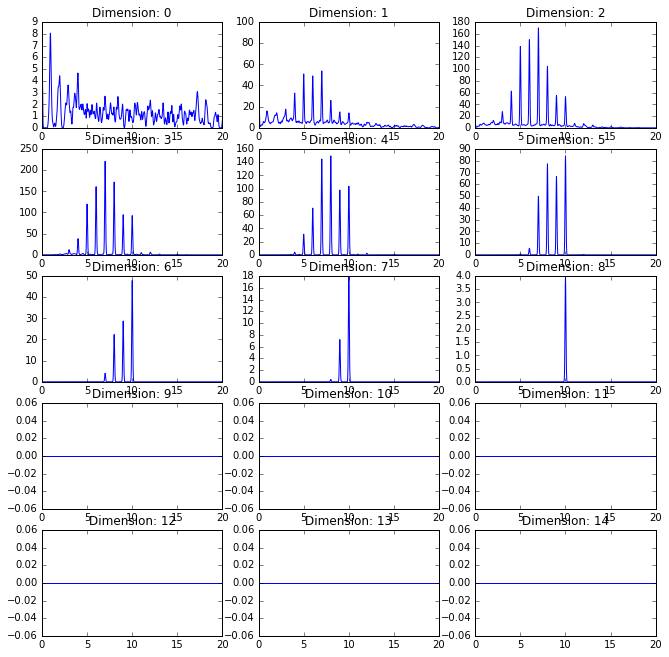

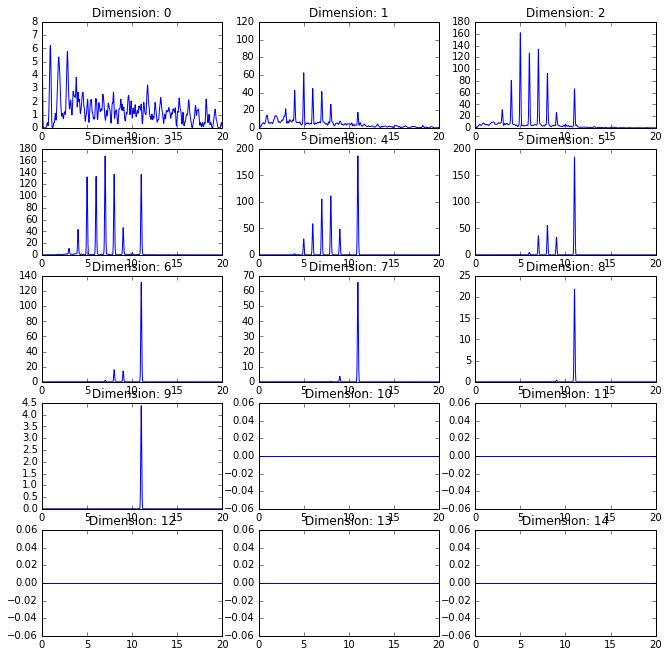

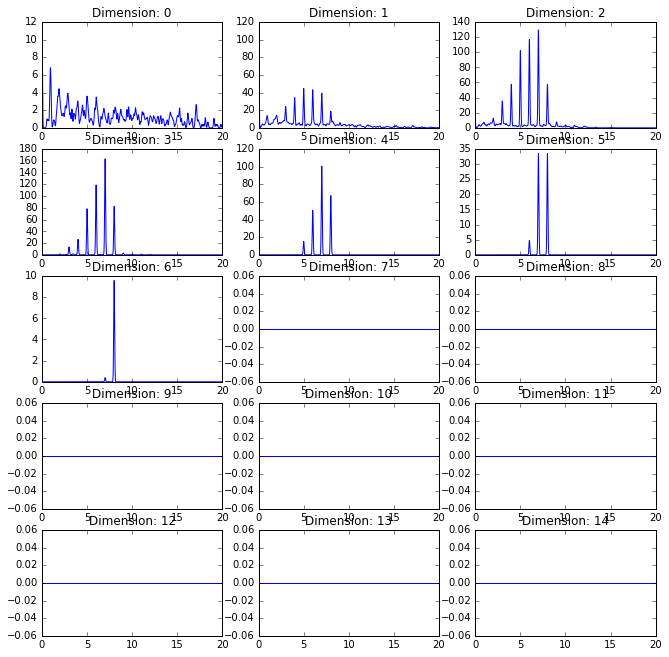

In [38]:
rows = 5

li=1000
for stim in avgs.keys():
    fig, axs = plt.subplots(rows,3, figsize=(11,11))
    for dim in range(3*rows):
        ax = axs.flatten()[dim]
        ax.plot(t[0:li], avgs[stim][0:li, dim])
        
        ax.set_title('Dimension: %d' % dim)

In [31]:
axs.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a392090>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x104114090>], dtype=object)

In [2]:
tstC = sc.SimplicialComplex([[1,2,3], [2,4], [3,4]])

In [3]:
tstC.updateAdjacency()

In [4]:
tstC.getLaplacian(0)

array([[ 3.,  0.,  0.,  1.],
       [ 0.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  0.],
       [ 1.,  0.,  0.,  3.]])

In [5]:
tstC.getLaplacian(1)

array([[ 3.,  0.,  0., -1.,  0.],
       [ 0.,  3.,  0.,  0., -1.],
       [ 0.,  0.,  3.,  1., -1.],
       [-1.,  0.,  1.,  2.,  1.],
       [ 0., -1., -1.,  1.,  2.]])

In [7]:
print([s.vertices for s in tstC.nSimplexDict[1]])

[[1, 2], [1, 3], [2, 3], [2, 4], [3, 4]]


In [8]:
def adjacencyToTopSimplices(adj):
    
    n = np.shape(adj)[0]
    topSimplexList = []
    for i in range(n):
        for j in range(i, n, 1):
            if adj[i, j]:
                topSimplexList.append([i,j])
    return topSimplexList

In [ ]:
adj = np.array([[0, 1, 1, 0], [1, 0, ]])